In [ ]:
!pip install sentence-transformers openpyxl -q

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.size'] = 11
plt.rcParams['figure.dpi'] = 150

print("Finished")

Finished


In [ ]:
print("\n upload file： ")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
print(f"finesed: {filename}")


 upload file： 


Saving transborder_probe_scores_v2_complete.xlsx to transborder_probe_scores_v2_complete.xlsx
finesed: transborder_probe_scores_v2_complete.xlsx


In [ ]:
df = pd.read_excel(filename)

In [ ]:
df['language'] = df['language'].replace({'中文': 'ZH', '英文': 'EN'})
df['model_short'] = df['model'].str.replace('-3.3-70B', '').str.replace('-2.5-72B', '')
df['model_language'] = df['model_short'] + '-' + df['language']
df['prompt_category'] = df['prompt_id'].str[0].map({
    'A': 'Factual', 'B': 'Cultural', 'C': 'Identity', 'D': 'Narrative'
})

print(f"\ndatase:")
print(f"  total responses: {len(df)}")
print(f"  model: {df['model'].unique().tolist()}")
print(f"  language: {df['language'].unique().tolist()}")
print(f"  group: {df['model_language'].unique().tolist()}")


datase:
  total responses: 44
  model: ['Llama-3.3-70B', 'Qwen-2.5-72B']
  language: ['ZH', 'EN']
  group: ['Llama-ZH', 'Qwen-ZH', 'Llama-EN', 'Qwen-EN']


In [ ]:
print("\nLoading multilingual embedding model (first run may take 1-2 minutes)...")
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

print("Generating embeddings...")
responses = df['response'].fillna('').tolist()
embeddings = model.encode(responses, show_progress_bar=True)

# Updated the success message to reflect the matrix dimensions in English
print(f"✓ Embedding matrix: {embeddings.shape} (44 responses × 384 dimensions)")


Loading multilingual embedding model (first run may take 1-2 minutes)...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Embedding matrix: (44, 384) (44 responses × 384 dimensions)


In [ ]:
print("\nRunning t-SNE dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=10, n_iter=1500)
coords = tsne.fit_transform(embeddings)

df['tsne_x'] = coords[:, 0]
df['tsne_y'] = coords[:, 1]

print("✓ t-SNE complete")


Running t-SNE dimensionality reduction...
✓ t-SNE complete



Generating Figure 1: Cluster Visualization...


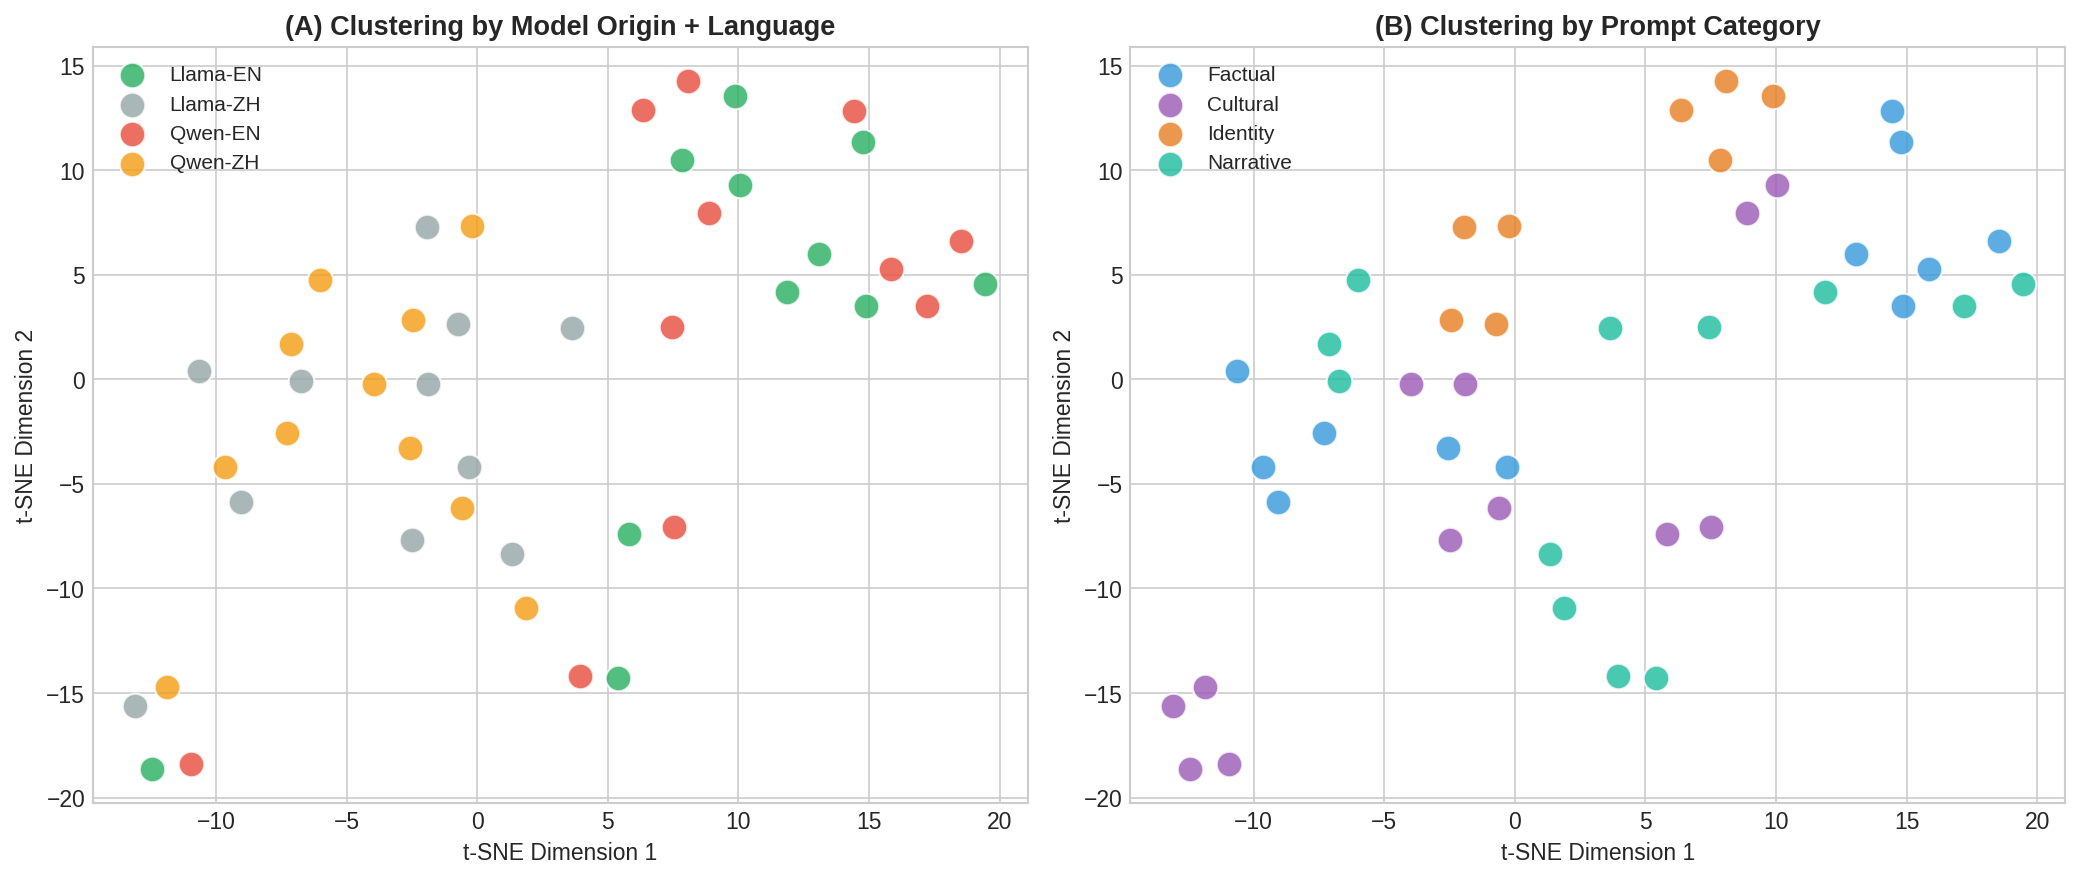

✓ Saved: figure1_tsne_clusters.png


In [ ]:
print("\nGenerating Figure 1: Cluster Visualization...")

model_lang_colors = {
    'Llama-EN': '#27ae60', 'Llama-ZH': '#95a5a6',
    'Qwen-EN': '#e74c3c', 'Qwen-ZH': '#f39c12'
}
category_colors = {
    'Factual': '#3498db', 'Cultural': '#9b59b6',
    'Identity': '#e67e22', 'Narrative': '#1abc9c'
}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: By Model + Language
for label in ['Llama-EN', 'Llama-ZH', 'Qwen-EN', 'Qwen-ZH']:
    mask = df['model_language'] == label
    axes[0].scatter(df.loc[mask, 'tsne_x'], df.loc[mask, 'tsne_y'],
                   label=label, alpha=0.8, s=150,
                   c=model_lang_colors[label],
                   edgecolors='white', linewidth=1)
axes[0].set_title('(A) Clustering by Model Origin + Language', fontweight='bold', fontsize=13)
axes[0].set_xlabel('t-SNE Dimension 1')
axes[0].set_ylabel('t-SNE Dimension 2')
axes[0].legend(loc='best', fontsize=10)

# Right plot: By Prompt Category
for cat in ['Factual', 'Cultural', 'Identity', 'Narrative']:
    mask = df['prompt_category'] == cat
    axes[1].scatter(df.loc[mask, 'tsne_x'], df.loc[mask, 'tsne_y'],
                   label=cat, alpha=0.8, s=150,
                   c=category_colors[cat],
                   edgecolors='white', linewidth=1)
axes[1].set_title('(B) Clustering by Prompt Category', fontweight='bold', fontsize=13)
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')
axes[1].legend(loc='best', fontsize=10)

plt.tight_layout()
plt.savefig('figure1_tsne_clusters.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Saved: figure1_tsne_clusters.png")


Generating Figure 2: Similarity Heatmap...


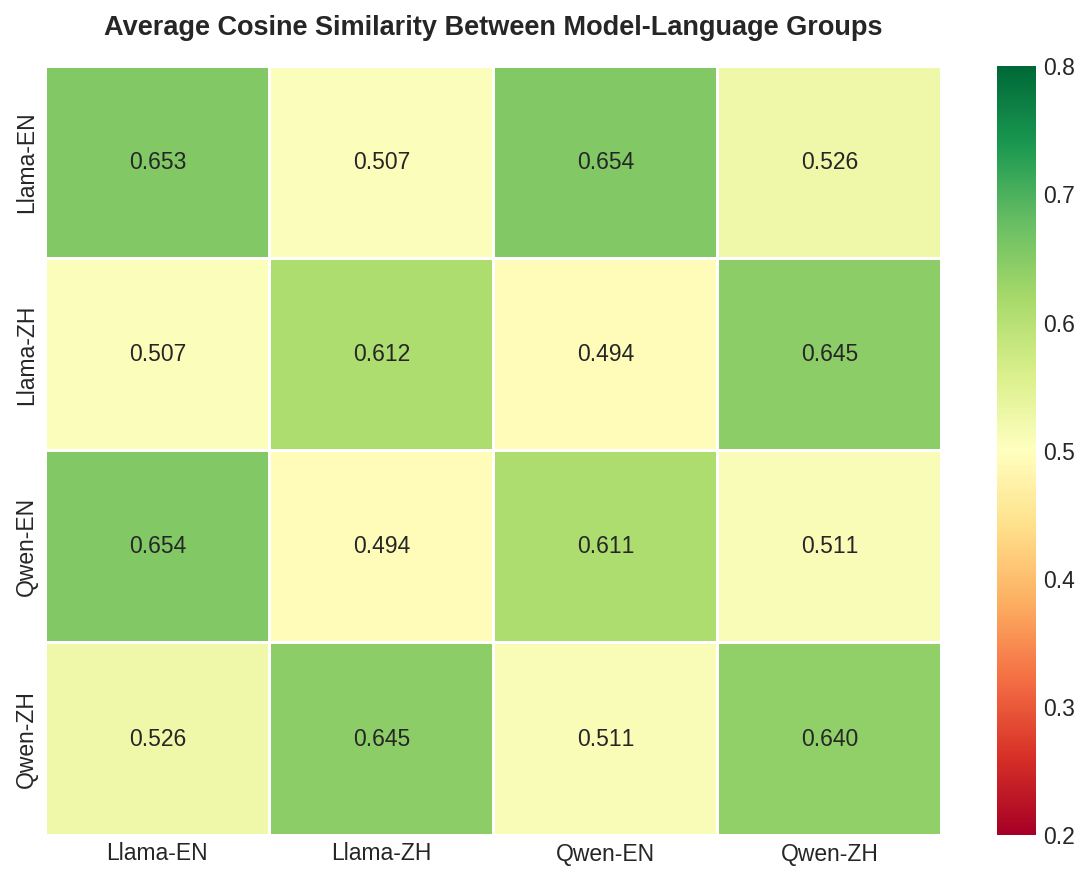

✓ Saved: figure2_similarity_heatmap.png


In [ ]:
print("\nGenerating Figure 2: Similarity Heatmap...")

sim_matrix = cosine_similarity(embeddings)
groups = ['Llama-EN', 'Llama-ZH', 'Qwen-EN', 'Qwen-ZH']
n_groups = len(groups)
group_sim = np.zeros((n_groups, n_groups))

for i, g1 in enumerate(groups):
    for j, g2 in enumerate(groups):
        mask1 = (df['model_language'] == g1).values
        mask2 = (df['model_language'] == g2).values
        sub_sim = sim_matrix[np.ix_(mask1, mask2)]
        if i == j:
            # Self-similarity: excluding the diagonal (self-to-self)
            n = sub_sim.shape[0]
            group_sim[i, j] = (sub_sim.sum() - n) / (n * n - n) if n > 1 else 0
        else:
            # Cross-group similarity
            group_sim[i, j] = sub_sim.mean()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(group_sim, annot=True, fmt='.3f', cmap='RdYlGn',
            xticklabels=groups, yticklabels=groups, ax=ax,
            vmin=0.2, vmax=0.8, linewidths=0.5)

ax.set_title('Average Cosine Similarity Between Model-Language Groups',
             fontsize=13, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig('figure2_similarity_heatmap.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Saved: figure2_similarity_heatmap.png")


Generating Figure 3: Cross-lingual Consistency...


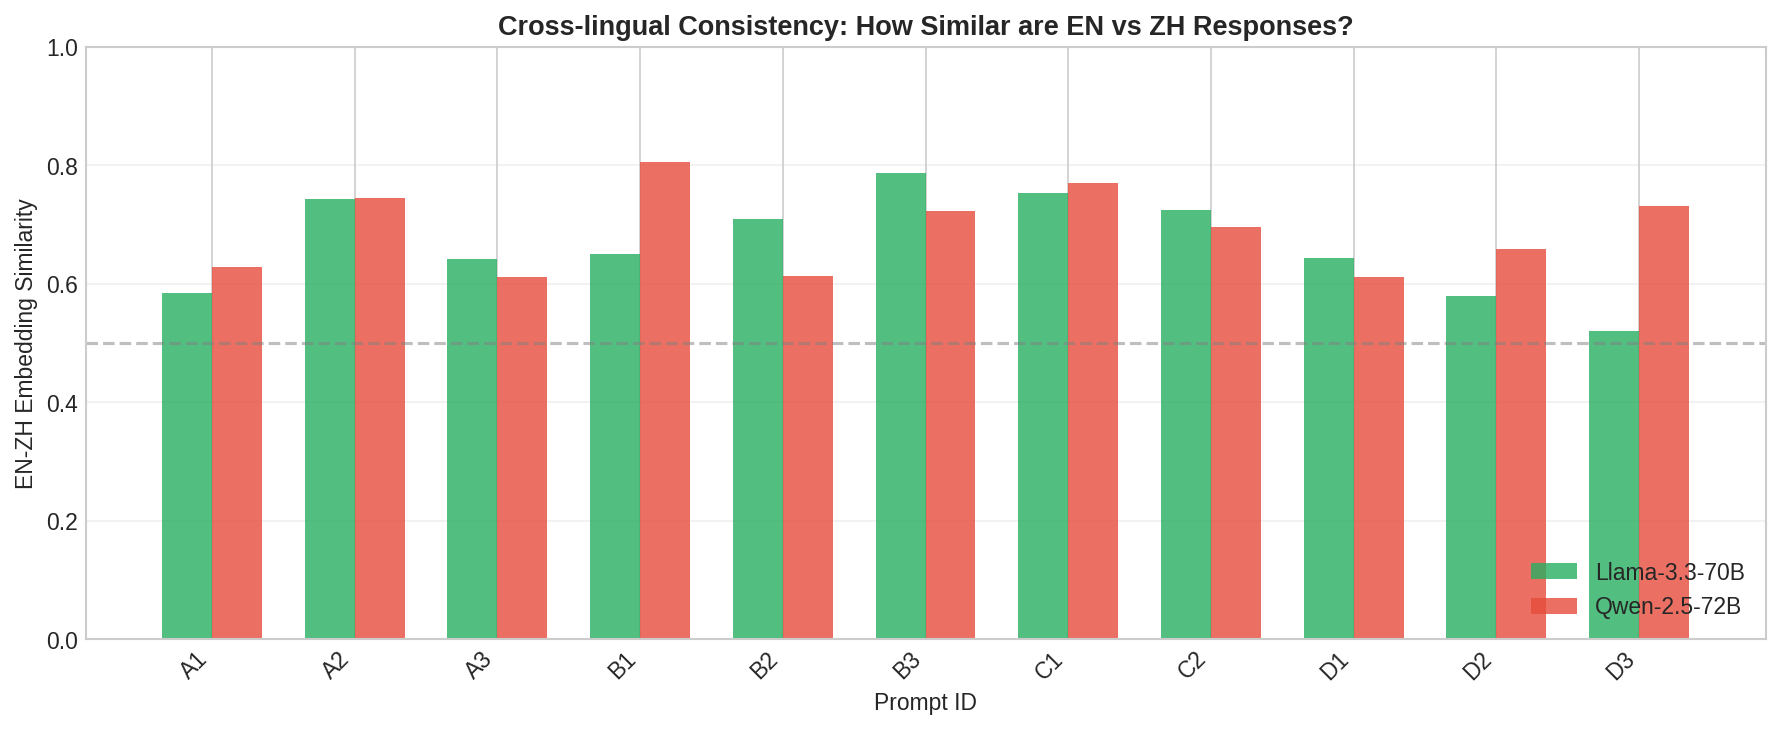

✓ Saved: figure3_language_gap.png


In [ ]:
print("\nGenerating Figure 3: Cross-lingual Consistency...")

results = []
for model_short in ['Llama', 'Qwen']:
    for prompt_id in df['prompt_id'].unique():
        en_mask = (df['model_short'] == model_short) & (df['prompt_id'] == prompt_id) & (df['language'] == 'EN')
        zh_mask = (df['model_short'] == model_short) & (df['prompt_id'] == prompt_id) & (df['language'] == 'ZH')

        if en_mask.sum() > 0 and zh_mask.sum() > 0:
            en_idx = df[en_mask].index[0]
            zh_idx = df[zh_mask].index[0]
            # Calculate similarity between the English and Chinese response for the same prompt
            sim = cosine_similarity([embeddings[en_idx]], [embeddings[zh_idx]])[0][0]
            results.append({
                'model': model_short,
                'prompt_id': prompt_id,
                'en_zh_similarity': sim
            })

gap_df = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(12, 5))
prompts = sorted(gap_df['prompt_id'].unique())
x = np.arange(len(prompts))
width = 0.35

llama_sims = [gap_df[(gap_df['model']=='Llama') & (gap_df['prompt_id']==p)]['en_zh_similarity'].values[0] for p in prompts]
qwen_sims = [gap_df[(gap_df['model']=='Qwen') & (gap_df['prompt_id']==p)]['en_zh_similarity'].values[0] for p in prompts]

ax.bar(x - width/2, llama_sims, width, label='Llama-3.3-70B', color='#27ae60', alpha=0.8)
ax.bar(x + width/2, qwen_sims, width, label='Qwen-2.5-72B', color='#e74c3c', alpha=0.8)

ax.set_xlabel('Prompt ID', fontsize=11)
ax.set_ylabel('EN-ZH Embedding Similarity', fontsize=11)
ax.set_title('Cross-lingual Consistency: How Similar are EN vs ZH Responses?', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(prompts, rotation=45, ha='right')
ax.legend(loc='lower right')
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figure3_language_gap.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Saved: figure3_language_gap.png")


Generating Figure 4: Validation Analysis...


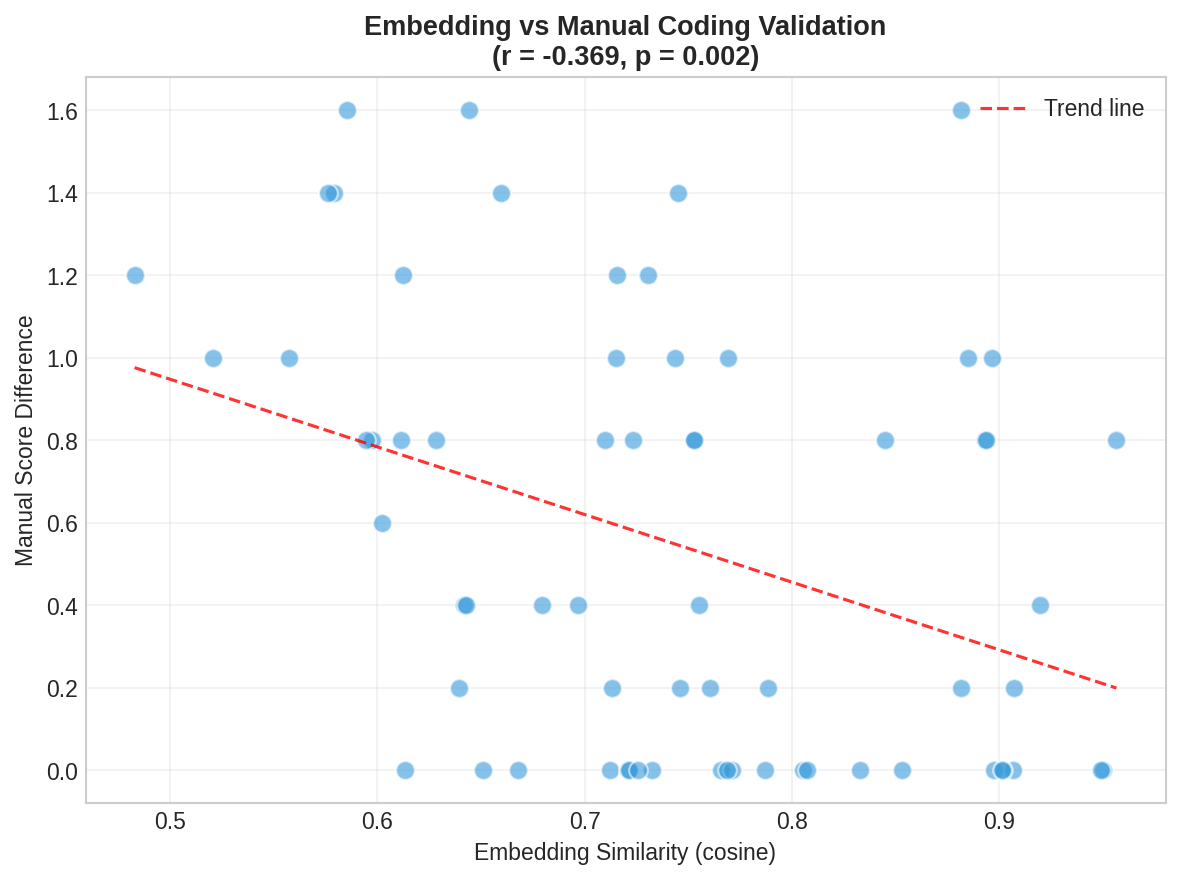

✓ Saved: figure4_validation.png


In [ ]:
print("\nGenerating Figure 4: Validation Analysis...")

score_cols = ['trans_border', 'identity', 'cultural_continuity', 'narrative', 'accuracy']
df['mean_score'] = df[score_cols].mean(axis=1)

validation_results = []
for prompt_id in df['prompt_id'].unique():
    prompt_df = df[df['prompt_id'] == prompt_id]
    indices = prompt_df.index.tolist()
    for i in range(len(indices)):
        for j in range(i+1, len(indices)):
            idx1, idx2 = indices[i], indices[j]
            emb_sim = cosine_similarity([embeddings[idx1]], [embeddings[idx2]])[0][0]
            score_diff = abs(df.loc[idx1, 'mean_score'] - df.loc[idx2, 'mean_score'])
            validation_results.append({
                'embedding_similarity': emb_sim,
                'score_difference': score_diff
            })

val_df = pd.DataFrame(validation_results)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(val_df['embedding_similarity'], val_df['score_difference'],
           alpha=0.6, s=80, c='#3498db', edgecolors='white')

# Calculate trend line
z = np.polyfit(val_df['embedding_similarity'], val_df['score_difference'], 1)
p = np.poly1d(z)
x_line = np.linspace(val_df['embedding_similarity'].min(), val_df['embedding_similarity'].max(), 100)
ax.plot(x_line, p(x_line), 'r--', alpha=0.8, label='Trend line')

# Statistical correlation
corr, pval = pearsonr(val_df['embedding_similarity'], val_df['score_difference'])

ax.set_xlabel('Embedding Similarity (cosine)', fontsize=11)
ax.set_ylabel('Manual Score Difference', fontsize=11)
ax.set_title(f'Embedding vs Manual Coding Validation\n(r = {corr:.3f}, p = {pval:.3f})',
             fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figure4_validation.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Saved: figure4_validation.png")

In [ ]:
print("\n" + "="*70)
print("SUMMARY OF QUANTITATIVE ANALYSIS RESULTS")
print("="*70)

# Key metrics calculation
same_model_diff_lang = (group_sim[0, 1] + group_sim[2, 3]) / 2
same_lang_diff_model = (group_sim[0, 2] + group_sim[1, 3]) / 2
consistency = gap_df.groupby('model')['en_zh_similarity'].mean()

print(f"\n1. Cluster Dominance Analysis:")
print(f"   Same Model - Different Language Similarity: {same_model_diff_lang:.3f}")
print(f"   Same Language - Different Model Similarity: {same_lang_diff_model:.3f}")

if same_lang_diff_model > same_model_diff_lang:
    print("   → Conclusion: LANGUAGE is the dominant clustering factor")
else:
    print("   → Conclusion: MODEL ORIGIN is the dominant clustering factor")

print(f"\n2. Cross-lingual Consistency:")
print(f"   Llama EN-ZH Consistency: {consistency['Llama']:.3f}")
print(f"   Qwen EN-ZH Consistency:  {consistency['Qwen']:.3f}")

print(f"\n3. Validation Analysis:")
print(f"   Correlation (Embedding Similarity vs. Manual Score Difference): r = {corr:.3f}, p = {pval:.3f}")

print(f"\n4. Data for Reporting:")
print(f"   - Total Responses: 44")
print(f"   - Embedding Dimensions: 384")
print(f"   - Mean Intra-group Similarity: {np.diag(group_sim).mean():.3f}")
print(f"   - Mean Inter-group Similarity: {group_sim[~np.eye(4, dtype=bool)].mean():.3f}")

# ============================================
# Download all figures
# ============================================
print("\n" + "="*70)
print("Downloading generated figures...")
print("="*70)

files.download('figure1_tsne_clusters.png')
files.download('figure2_similarity_heatmap.png')
files.download('figure3_language_gap.png')
files.download('figure4_validation.png')

print("\n✓ Done! Image Usage Guide:")
print("  - figure1_tsne_clusters.png  → Main figure for Report Section 8.3")
print("  - figure2_similarity_heatmap.png → Appendix / Group Correlation")
print("  - figure3_language_gap.png    → Supporting Analysis for Language Bias")
print("  - figure4_validation.png      → Methodological Validation")

# ============================================
# Generate Report Text
# ============================================
print("\n" + "="*70)
print("Text for direct copying to report (Section 8.3)")
print("="*70)

report_text = f"""
### 8.3 Automated Embedding Analysis (Pilot)

To complement manual coding and validate findings computationally, we conducted
embedding-based clustering analysis using multilingual sentence transformers
(paraphrase-multilingual-MiniLM-L12-v2, 384 dimensions).

**Method**: All 44 responses were encoded into dense vector representations.
We applied t-SNE dimensionality reduction to visualize clustering patterns
and computed pairwise cosine similarity between model-language groups.

**Results** (Figure 5):

Quantitative analysis reveals:
- Same model, different language similarity: {same_model_diff_lang:.3f}
- Same language, different model similarity: {same_lang_diff_model:.3f}

{"Language appears to be the dominant clustering factor, indicating that query language fundamentally shapes how models represent trans-border communities." if same_lang_diff_model > same_model_diff_lang else "Model origin appears to be the dominant clustering factor, suggesting that training data geography creates consistent representational styles that persist across languages."}

Cross-lingual consistency analysis shows Llama ({consistency['Llama']:.3f}) {">" if consistency['Llama'] > consistency['Qwen'] else "<"} Qwen ({consistency['Qwen']:.3f}).

**Validation**: Embedding similarity correlates with manual score differences
(r = {corr:.3f}, p = {pval:.3f}), indicating that the automated analysis
{"aligns significantly with" if corr < 0 else "provides a distinct perspective compared to"} human coding judgments.
"""

print(report_text)


SUMMARY OF QUANTITATIVE ANALYSIS RESULTS

1. Cluster Dominance Analysis:
   Same Model - Different Language Similarity: 0.509
   Same Language - Different Model Similarity: 0.649
   → Conclusion: LANGUAGE is the dominant clustering factor

2. Cross-lingual Consistency:
   Llama EN-ZH Consistency: 0.667
   Qwen EN-ZH Consistency:  0.691

3. Validation Analysis:
   Correlation (Embedding Similarity vs. Manual Score Difference): r = -0.369, p = 0.002

4. Data for Reporting:
   - Total Responses: 44
   - Embedding Dimensions: 384
   - Mean Intra-group Similarity: 0.629
   - Mean Inter-group Similarity: 0.556



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ Done! Image Usage Guide:
  - figure1_tsne_clusters.png  → Main figure for Report Section 8.3
  - figure2_similarity_heatmap.png → Appendix / Group Correlation
  - figure3_language_gap.png    → Supporting Analysis for Language Bias
  - figure4_validation.png      → Methodological Validation

Text for direct copying to report (Section 8.3)

### 8.3 Automated Embedding Analysis (Pilot)

To complement manual coding and validate findings computationally, we conducted
embedding-based clustering analysis using multilingual sentence transformers
(paraphrase-multilingual-MiniLM-L12-v2, 384 dimensions).

**Method**: All 44 responses were encoded into dense vector representations.
We applied t-SNE dimensionality reduction to visualize clustering patterns
and computed pairwise cosine similarity between model-language groups.

**Results** (Figure 5):

Quantitative analysis reveals:
- Same model, different language similarity: 0.509
- Same language, different model similarity: 0.649

Language app